In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
import os
from shutil import copyfile
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model


#for dirname, _, filenames in os.walk('/kaggle/input'):
   #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing the data

In [4]:
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

train_path = '/kaggle/temp/seg_train/'
test_path = '/kaggle/temp/seg_test/'

pred_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'


## Sample photos 

forest sample image


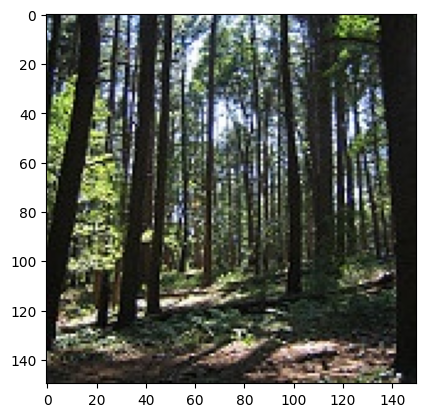


building sample image


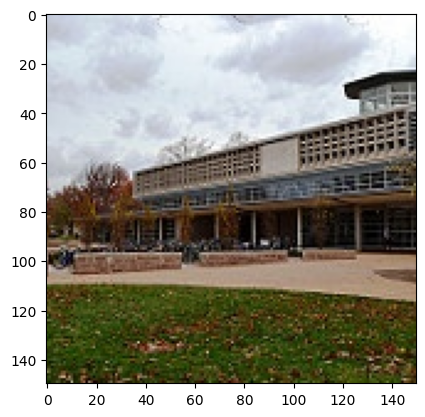

In [5]:
file_list = os.listdir(os.path.join(train_dir,'forest'))


print("forest sample image")
plt.imshow(load_img(f"{os.path.join(train_dir,'forest', os.listdir(os.path.join(train_dir,'forest'))[0])}" ))
plt.show()

print("\nbuilding sample image")
plt.imshow(load_img(f"{os.path.join(train_dir,'buildings', os.listdir(os.path.join(train_dir,'buildings'))[0])}"))
plt.show()

## Count training and testing files and inspect for zero lenght images

In [6]:

def count_files_in_folder(source_dir, new_path):
    
    #remove files with zero lenght and save in the new dirrectory 
    zero_length_files = []
    for dirr in os.listdir(source_dir):
        new_subdir = os.path.join(new_path, dirr)
        os.makedirs(new_subdir)
        for img in os.listdir(os.path.join(source_dir, dirr)):
            if os.path.getsize(os.path.join(source_dir, dirr, img)) !=0:
                copyfile(os.path.join(source_dir, dirr, img), os.path.join(new_subdir,img))
            else:
                zero_length_files.append(img)
                print(f"{img} is zero length, so ignoring")
        
    total_files = 0
    #Walk through all directories and subdirectories
    for root, dirs, files in os.walk(new_path):
        total_files += len(files)
    #directories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
    #return directories
    if len(zero_length_files) == 0:
        print("No zero length files found.")

    return (total_files)

In [7]:
train_files = count_files_in_folder(train_dir,train_path)
test_files = count_files_in_folder(test_dir,test_path)

print(f"There are {train_files} files in the training set")
print(f"there are {test_files} files in the testing set")

No zero length files found.
No zero length files found.
There are 14034 files in the training set
there are 3000 files in the testing set


## Creating Image Data Generators for loading the data and preprocing it

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   height_shift_range= 0.2,
                                    shear_range= 0.2,
                                     zoom_range= 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (300, 300),
                                                    batch_size = 128, 
                                                    class_mode = 'sparse'
                                                   )
val_generator = val_datagen.flow_from_directory(directory = test_dir,
                                                target_size = (300, 300),
                                                batch_size = 64, 
                                                class_mode = 'sparse')

pred_datagen = ImageDataGenerator(rescale = 1./255)
pred_generator = pred_datagen.flow_from_directory(directory = pred_dir,
                                                target_size = (300, 300),
                                                batch_size = 64)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## 1. Creating a basic model and testing different learining rate 

In [9]:
  model_lr = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (300, 300, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32,(3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64,(3, 3), activation = 'relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(510, activation = 'relu'),
      tf.keras.layers.Dense(6, activation = 'softmax')
  ])
  model_lr.compile(optimizer = Adam(learning_rate= 1e-6),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20)) 



In [ ]:
history_lr = model_lr.fit(train_generator,
                    validation_data= val_generator,
                   epochs= 30,
                   callbacks=[lr_schedule])

Epoch 1/30
110/110 [==============================] - 906s 8s/step - loss: 1.1536 - accuracy: 0.5548 - val_loss: 1.0198 - val_accuracy: 0.6273 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - 902s 8s/step - loss: 0.8907 - accuracy: 0.6727 - val_loss: 0.8835 - val_accuracy: 0.6843 - lr: 1.1220e-04
Epoch 3/30
 38/110 [=========>....................] - ETA: 9:21 - loss: 0.8049 - accuracy: 0.7066

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.title('Basic model loss')
plt.xlabel('Learning Rate (log scale)')  # Add x-axis label
plt.ylabel('Loss')  # Add y-axis label
plt.axis([1e-4, 10, 0, 2])
plt.show()

In [ ]:
Train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(Train_acc))

plt.plot(epochs, Train_acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## The basic model is overfitted to the training data. I will choose 2.8184e-04 as the alpha value since the model is still learning at this point. 

## 2. Creating a model using Transfer Learning from inceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model = InceptionV3(input_shape = ( 300 , 300 , 3),       #here the res and the dimention
                                  include_top = False)
base_model.trainable = False
base_model.summary()


In [ ]:
trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])
print(f"Number of trainable parameter in the base model: {trainable_params:,} ")

In [ ]:
desired_layer = base_model.get_layer('mixed7')
last_output = desired_layer.output
x = layers.Flatten()(last_output)
#x = layers.Dense(units = 20, activation = 'relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense( units = 6, activation = 'softmax')(x)
tr_model = Model(inputs = base_model.input, outputs = x)

tr_model.compile(optimizer = Adam(learning_rate= 1.2e-4),
              loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
history_lr = tr_model.fit(train_generator,
                    validation_data= val_generator,
                   epochs= 10,
                callbacks=[lr_schedule]
                         )

## Model prediction 

In [ ]:
tr_predictions = tr_model.predict_generator(test_generator)

## upload data for prediction 

In [ ]:
import tkinter as tk
from tkinter import filedialog

In [ ]:
def ask_for_image_path():
    root = tk.Tk()
    root.withdraw()

    file_path = filedialog.askopenfilename(title="Select Image File", filetypes=[("Image files", "*.png;*.jpg;*.jpeg;*.gif;*.bmp")])

    return file_path

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(299, 299))  # Adjust target_size based on your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

In [ ]:

image_path = ask_for_image_path()
processed_image = preprocess_image(image_path)
# Make predictions
predictions = model.predict(processed_image)
decoded_predictions = decode_predictions(predictions)

# Print the top predicted class and probability
top_prediction = decoded_predictions[0][0]
print(f"Predicted class: {top_prediction[1]}, Probability: {top_prediction[2]}")

# Now you can use the image_path variable to load or process the image